In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Weddell_Extent = pd.read_excel(filepath, sheet_name='Weddell-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Weddell_Extent)
fp.date_time(Weddell_Extent)

,Extent,Date
0,2136510.859,1979-01-01
1,1243495.891,1979-02-01
2,1699053.449,1979-03-01
3,2617442.085,1979-04-01
4,3852934.206,1979-05-01
...,...,...
533,3668127.143,2023-06-01
534,4805519.784,2023-07-01
535,5524445.234,2023-08-01
536,6006669.861,2023-09-01


In [5]:
scaler = MinMaxScaler()
Weddell_Extent['Extent'] = scaler.fit_transform(Weddell_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 10
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Weddell_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((517, 12, 1), (517,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(Bidirectional(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0))))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Weddell_model_LT10/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 39s 512ms/step - loss: 0.2702 - root_mean_squared_error: 0.5198 - val_loss: 0.1625 - val_root_mean_squared_error: 0.4031
Epoch 2/50
53/53 [==============================] - 25s 471ms/step - loss: 0.0989 - root_mean_squared_error: 0.3144 - val_loss: 0.0722 - val_root_mean_squared_error: 0.2687
Epoch 3/50
53/53 [==============================] - 25s 472ms/step - loss: 0.0577 - root_mean_squared_error: 0.2403 - val_loss: 0.0465 - val_root_mean_squared_error: 0.2156
Epoch 4/50
53/53 [==============================] - 25s 484ms/step - loss: 0.0317 - root_mean_squared_error: 0.1782 - val_loss: 0.0218 - val_root_mean_squared_error: 0.1477
Epoch 5/50
53/53 [==============================] - 25s 487ms/step - loss: 0.0171 - root_mean_squared_error: 0.1309 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1195
Epoch 6/50
53/53 [==============================] - 26s 490ms/step - loss: 0.0161 - root_mean_squared_error: 0.1268 - val_loss: 0.0113 

Epoch 33/50
53/53 [==============================] - 3s 59ms/step - loss: 0.0063 - root_mean_squared_error: 0.0794 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0679
Epoch 34/50
53/53 [==============================] - 4s 68ms/step - loss: 0.0059 - root_mean_squared_error: 0.0768 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0801
Epoch 35/50
53/53 [==============================] - 3s 65ms/step - loss: 0.0055 - root_mean_squared_error: 0.0744 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0685
Epoch 36/50
53/53 [==============================] - 4s 67ms/step - loss: 0.0055 - root_mean_squared_error: 0.0741 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0723
Epoch 37/50
53/53 [==============================] - 4s 69ms/step - loss: 0.0055 - root_mean_squared_error: 0.0744 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0691
Epoch 38/50
53/53 [==============================] - 4s 67ms/step - loss: 0.0055 - root_mean_squared_error: 0.0739 - val_loss: 0.0049 - val_

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

9.39558829466502 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

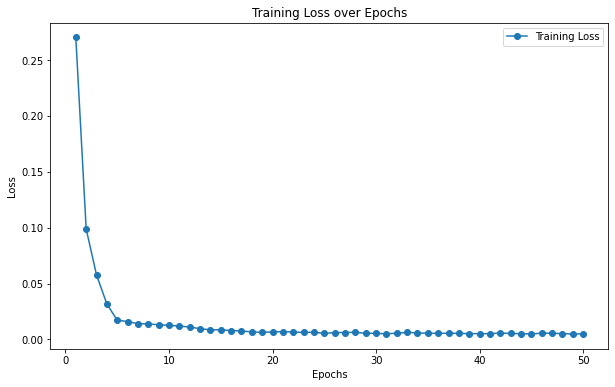

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

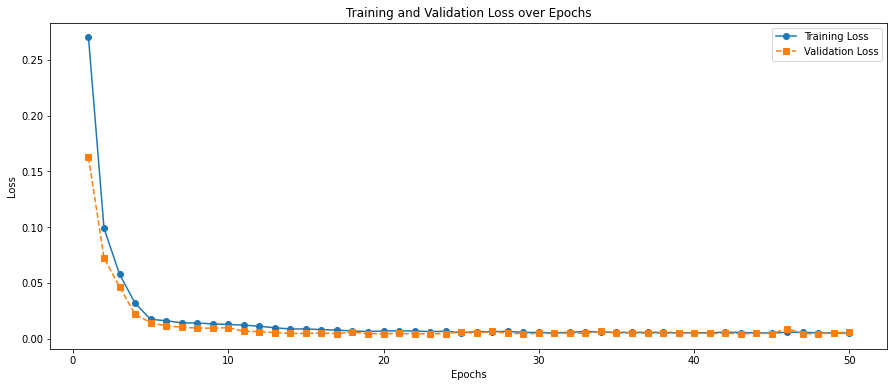

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Weddell_model_LT10/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 2s 34ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.06334530368635506
MAE : 0.052090665915951934


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,1.414202e+06,1292668.399
1,1.167733e+06,1527666.815
2,2.132432e+06,2121949.701
3,3.766351e+06,3562381.775
4,4.885194e+06,5004305.983
5,5.814644e+06,6176613.878
6,6.520768e+06,6794233.093
7,6.877782e+06,7024136.637
8,6.454088e+06,6554271.388
9,5.433006e+06,6172281.701


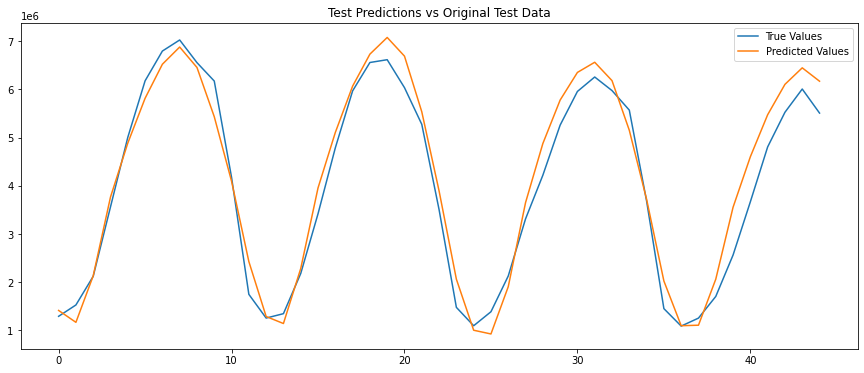

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 1s 41ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

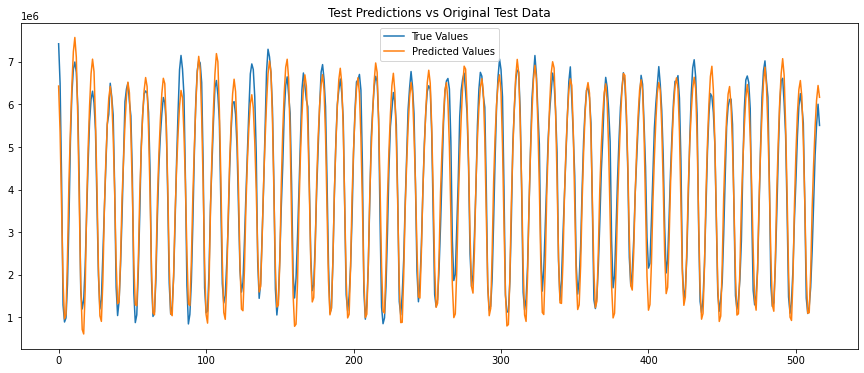

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()